<a href="https://colab.research.google.com/github/Shikhas/vandyhacksdj/blob/master/Event_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BeatBot - Event based Classification


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# load the required libraries
import pandas as pd 
import numpy as np
from fastai import *
from fastai.vision import *
import os
import glob
from PIL import Image
from PIL import ImageFile
from fastai.callbacks import *
import warnings
warnings.simplefilter('ignore')

In [0]:
# mount the drive 
from google.colab import drive

drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path = Path('/content/gdrive/Shared drives/VandyHacks/data')

## EDA

In [0]:
# Define classes
classes = ['birthday','christmas','halloween','party','wedding']

In [0]:
# Remove images that do not open
for c in classes:
  print(c)
  verify_images(path/c, delete=False, max_size=10000)

In [0]:
for c in classes:
  print("Number of {} images: {}".format(c, str(len(get_image_files(path/c)))))

Number of birthday images: 272
Number of christmas images: 252
Number of halloween images: 275
Number of party images: 267
Number of wedding images: 275


In [0]:
# Create Dataloaders
np.random.seed(1234)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [0]:
data

ImageDataBunch;

Train: LabelList (1073 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
wedding,wedding,wedding,wedding,wedding
Path: /content/gdrive/Shared drives/VandyHacks/data;

Valid: LabelList (268 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
christmas,birthday,party,wedding,halloween
Path: /content/gdrive/Shared drives/VandyHacks/data;

Test: None

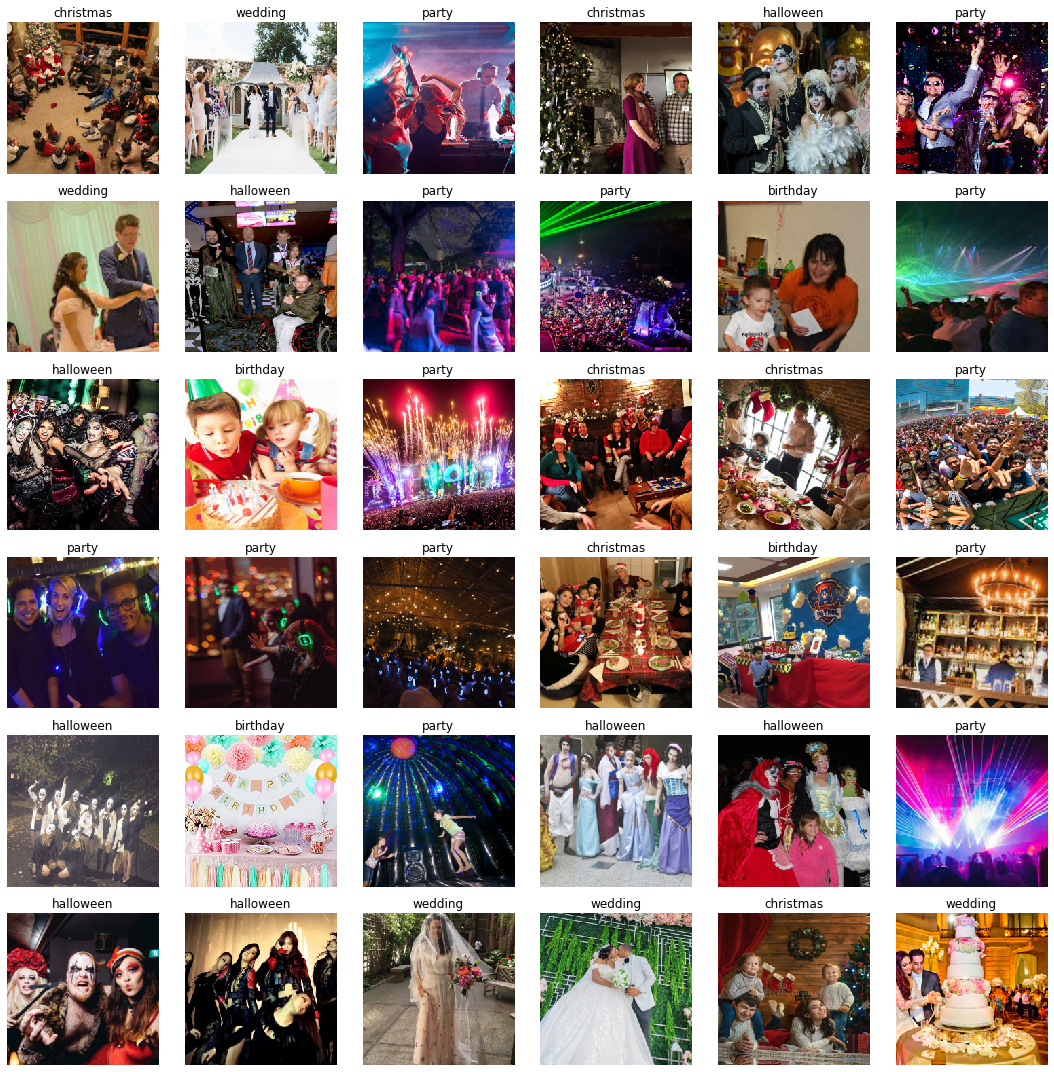

In [0]:
# Visualize Data
data.show_batch(rows=6, figsize=(15,15))

In [0]:
train_counts_list = list(map(lambda r: str(r), data.train_ds.y))
ddt = pd.DataFrame(train_counts_list, columns=['labels'])
train_counts = ddt['labels'].value_counts().reset_index()
train_counts

index  labels
0   birthday     227
1    wedding     219
2  halloween     212
3      party     211
4  christmas     204

In [0]:
valid_counts_list = list(map(lambda r: str(r), data.valid_ds.y))
ddv = pd.DataFrame(valid_counts_list, columns=['labels'])
valid_counts = ddv['labels'].value_counts().reset_index()
valid_counts

index  labels
0  halloween      63
1    wedding      56
2      party      56
3  christmas      48
4   birthday      45

## Train Model


In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy], callback_fns=[ShowGraph])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 76.6MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-03
Min loss divided by 10: 1.00E-02


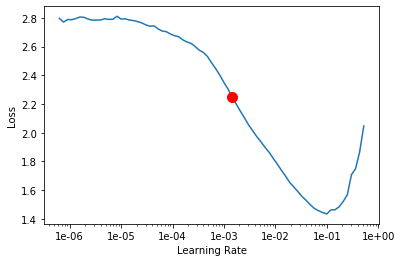

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

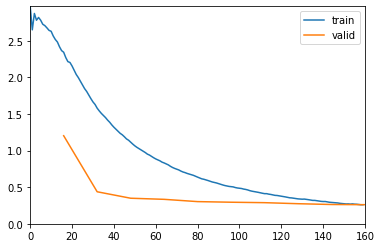

Better model found at epoch 0 with valid_loss value: 1.2035280466079712.
Better model found at epoch 1 with valid_loss value: 0.43778952956199646.
Better model found at epoch 2 with valid_loss value: 0.34943869709968567.
Better model found at epoch 3 with valid_loss value: 0.3343798518180847.
Better model found at epoch 4 with valid_loss value: 0.3032064437866211.
Better model found at epoch 5 with valid_loss value: 0.2948455214500427.
Better model found at epoch 6 with valid_loss value: 0.28873953223228455.
Better model found at epoch 7 with valid_loss value: 0.27455630898475647.
Better model found at epoch 8 with valid_loss value: 0.2637183368206024.
Better model found at epoch 9 with valid_loss value: 0.26130247116088867.


In [0]:
# First Stage Training
learn.fit_one_cycle(10, max_lr=(1e-03),callbacks=SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage1-1'))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.00E-04


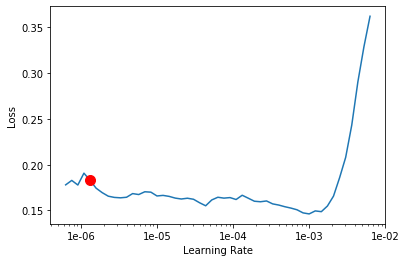

In [0]:
learn.load('resnet34_stage-1')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

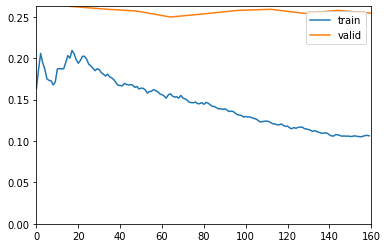

Better model found at epoch 0 with valid_loss value: 0.26257747411727905.
Better model found at epoch 1 with valid_loss value: 0.25940442085266113.
Better model found at epoch 2 with valid_loss value: 0.2568609118461609.
Better model found at epoch 3 with valid_loss value: 0.2497049868106842.


In [0]:
# Second Stage training
learn.fit_one_cycle(10, max_lr=slice(1e-04),callbacks=SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage1-2'))

## Results

In [0]:
learn.load('stage1-2')

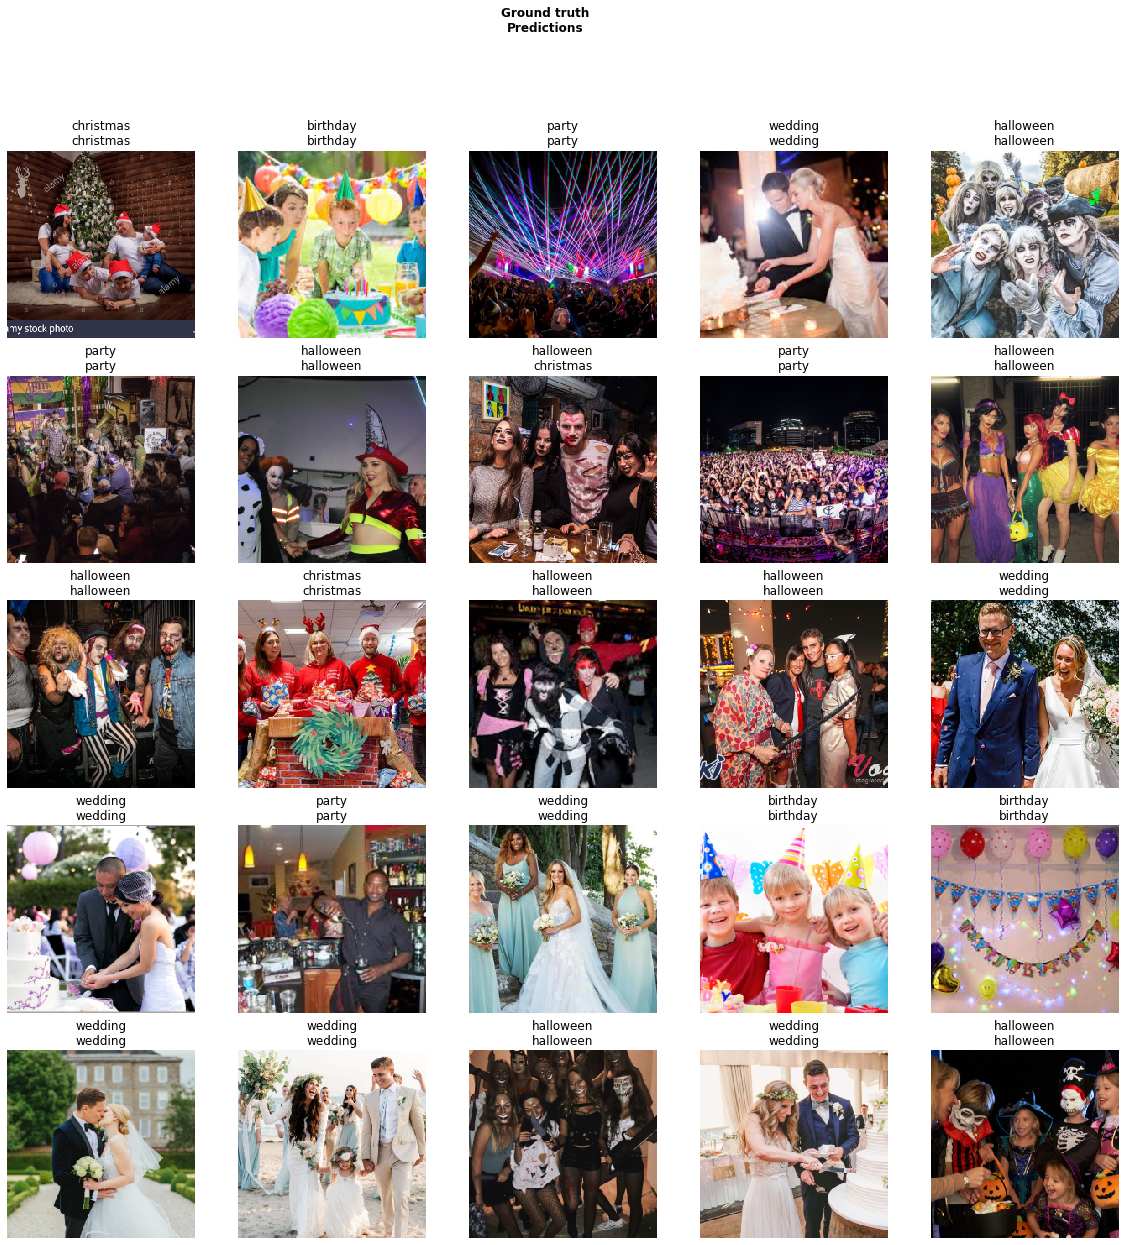

In [0]:
learn.show_results()

In [0]:
valid_interp = ClassificationInterpretation.from_learner(learn)

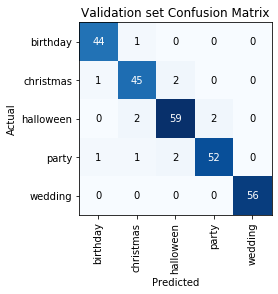

In [0]:
# Plot Validation Set Confusion Matrix
valid_interp.plot_confusion_matrix(title="Validation set Confusion Matrix")

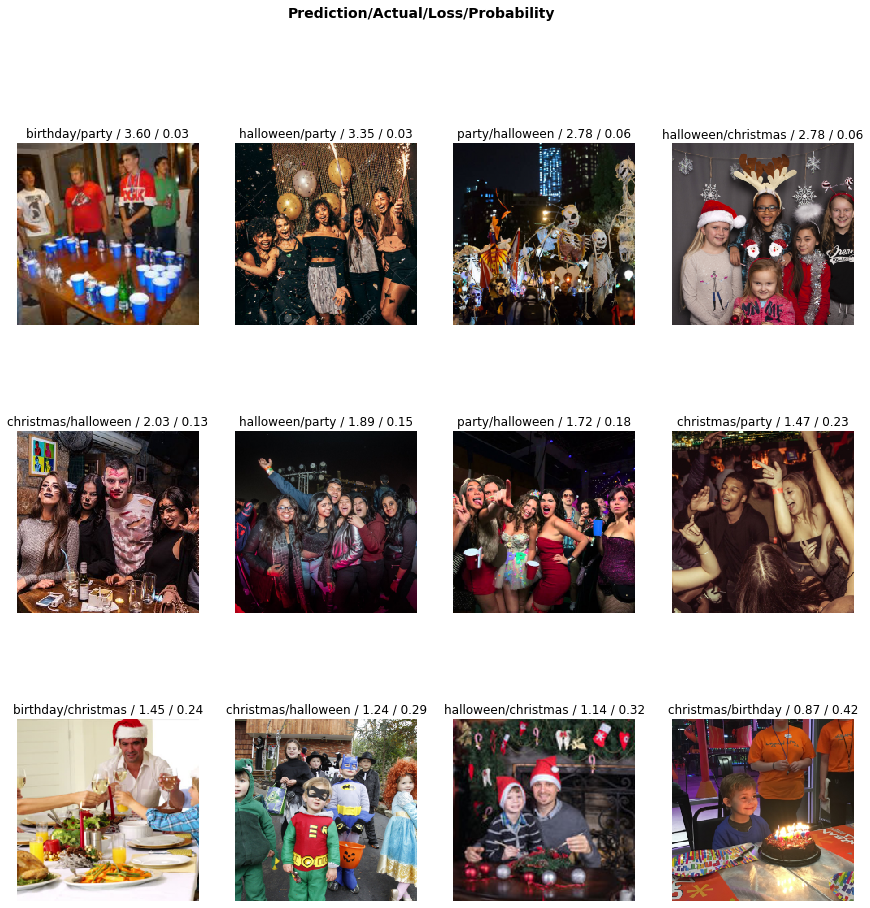

In [0]:
# Plot Top Losses
valid_interp.plot_top_losses(12, figsize=(15,15))

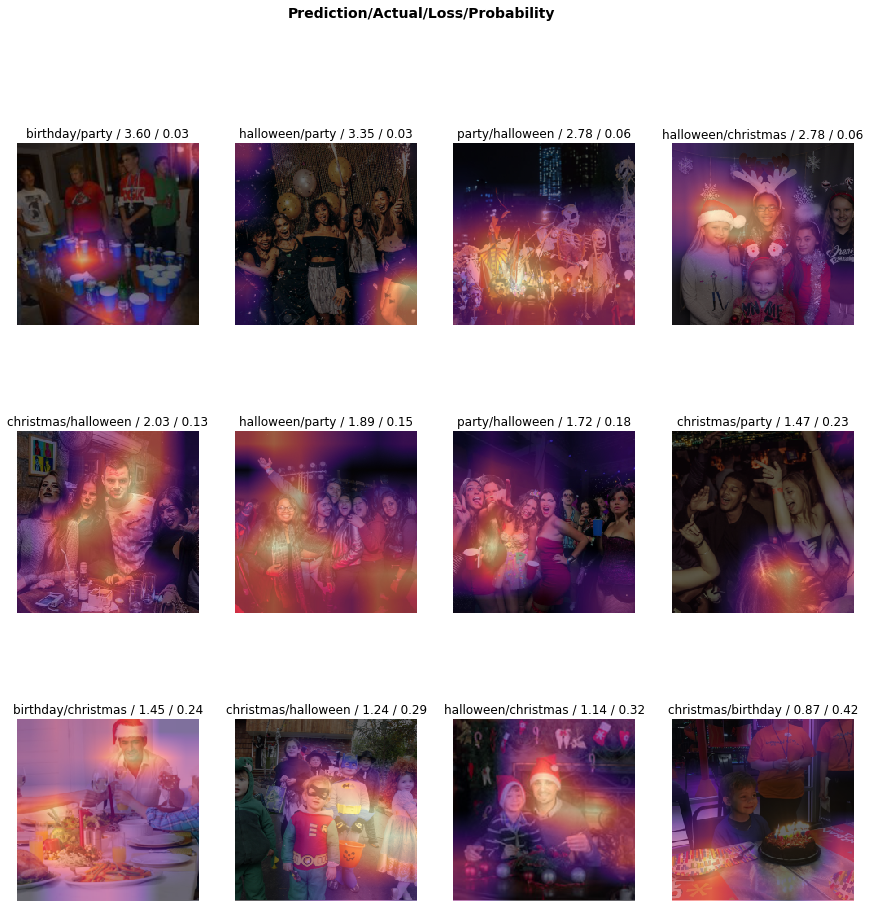

In [0]:
valid_interp.plot_top_losses(12, figsize=(15,15), heatmap=True)

In [0]:
learn.export('model_v1.pkl')